# Detecting Anomalous Streams in the Pen Digit Dataset

In this notebook, we will use the [Pen Digit](https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits) dataset to illustrate the use of the anomaly detection algorithms. See the [pen_digit_anomalies_data.ipynb](pen_digit_anomalies_data.ipynb) for the data download and preparation.

In [1]:
from __future__ import annotations
import random
import time
from typing import Callable

import numpy as np
import pandas as pd

import Data
from signature_mahalanobis_knn.utils import (
    compute_auc_given_dists,
    plot_cdf_given_dists,
)

from methods import (
    compute_signature_mahalanbois_knn_scores,
    compute_isolation_forest_scores_based_on_moments,
    compute_isolation_forest_scores_signatures,
    compute_local_outlier_factor_scores_based_on_moments,
    compute_local_outlier_factor_scores_signatures,
)

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)

bootstrap_samples = 10000

In [3]:
data = Data.Data(if_sample=False, random_seed=seed)
data.load_pen_digit()

depths = [1, 2, 3, 4, 5]
digits = range(10)

In [4]:
def pen_digit_experiment(
    data: Data.Data,
    depths: list[int],
    digits: list[int] | list[None],
    anomaly_detection_method: Callable[[Data.Data], dict[str, np.array | float]],
    anomaly_detection_kwargs: dict | None = None,
    add_depth_to_kwargs: bool = False,
    plot_kwargs: dict | None = None,
) -> dict[str, np.array | float]:
    t0 = time.time()

    if anomaly_detection_kwargs is None:
        anomaly_detection_kwargs = {}
    if plot_kwargs is None:
        plot_kwargs = {}

    results_pen_digit = {
        "depth": [],
        "auc": [],
        "se": [],
        "fit_times": [],
        "mean_fit_time": [],
        "total_fit_time": [],
        "compute_score_times": [],
        "mean_compute_score_time": [],
        "total_compute_score_time": [],
    }

    # loop through signatures depths
    for depth in depths:
        results_pen_digit["depth"].append(depth)
        digit_to_inlier_dists = {}
        digit_to_outlier_dists = {}
        fit_times = []
        compute_times = []

        # loop through the digits to compute inlier and outlier distances
        for digit in digits:
            data.load_pen_digit(digit=digit)
            print(f"start digit: {digit}, depth: {depth}")

            if add_depth_to_kwargs:
                anomaly_detection_kwargs["depth"] = depth

            # compute the inlier and outlier scores
            results = anomaly_detection_method(data, **anomaly_detection_kwargs)

            # save the inlier and outlier distances for digit
            digit_to_inlier_dists[digit] = results["scores_inliers"]
            digit_to_outlier_dists[digit] = results["scores_outliers"]

            # save fit and compute times
            fit_times.append(results["fit_time"])
            compute_times.append(results["compute_score_time"])

            # compute auc for digit
            auc = compute_auc_given_dists(
                results["scores_inliers"], results["scores_outliers"]
            )
            print(f"depth: {depth}, digit: {digit} | auc: {auc}")

        # plot and compute auc
        all_inlier_dists = np.concatenate(list(digit_to_inlier_dists.values()))
        all_outlier_dists = np.concatenate(list(digit_to_outlier_dists.values()))
        auc, se = compute_auc_given_dists(
            all_inlier_dists,
            all_outlier_dists,
            bootstrap=True,
            bootstrap_samples=bootstrap_samples,
            random_state=seed,
            plot=True,
            title=f"Pen Digit (depth={depth})",
        )

        # save results
        results_pen_digit["auc"].append(auc)
        results_pen_digit["se"].append(se)
        results_pen_digit["fit_times"].append(fit_times)
        results_pen_digit["mean_fit_time"].append(np.mean(fit_times))
        results_pen_digit["total_fit_time"].append(np.sum(fit_times))
        results_pen_digit["compute_score_times"].append(compute_times)
        results_pen_digit["mean_compute_score_time"].append(np.mean(compute_times))
        results_pen_digit["total_compute_score_time"].append(np.sum(compute_times))

        # plot CDF
        plot_cdf_given_dists(
            all_inlier_dists,
            all_outlier_dists,
            bins=10000000,
            **plot_kwargs,
        )

        print(f"[Overall] depth: {depth} | auc: {auc}, se: {se}")

    total_time = time.time() - t0
    print(f"Total experiment time: {total_time} seconds | {total_time / 60} minutes")

    return results_pen_digit

## Signature Mahalanobis KNN

In [5]:
n_neighbours = 100

start digit: 0, depth: 1
fit_time: 4.322498083114624
compute_score_time: 1.1335527896881104
depth: 1, digit: 0 | auc: 0.9236207222288126
start digit: 1, depth: 1
fit_time: 0.24246668815612793


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.071739673614502
depth: 1, digit: 1 | auc: 0.8300117639221022
start digit: 2, depth: 1
fit_time: 0.24335885047912598


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0874698162078857
depth: 1, digit: 2 | auc: 0.9320068093999172
start digit: 3, depth: 1
fit_time: 0.21210098266601562
compute_score_time: 1.0787560939788818
depth: 1, digit: 3 | auc: 0.9220223035450739
start digit: 4, depth: 1
fit_time: 0.2609729766845703


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0300321578979492
depth: 1, digit: 4 | auc: 0.9830396151391685
start digit: 5, depth: 1
fit_time: 0.19927191734313965


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.1829102039337158
depth: 1, digit: 5 | auc: 0.9057290216637331
start digit: 6, depth: 1
fit_time: 0.21843791007995605


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0973422527313232
depth: 1, digit: 6 | auc: 0.8962098280172284
start digit: 7, depth: 1
fit_time: 0.25840091705322266
compute_score_time: 0.9953699111938477
depth: 1, digit: 7 | auc: 0.8957924255068479
start digit: 8, depth: 1
fit_time: 0.2195429801940918
compute_score_time: 1.0493018627166748
depth: 1, digit: 8 | auc: 0.9399820412035783
start digit: 9, depth: 1
fit_time: 0.2072157859802246
compute_score_time: 1.0743422508239746
depth: 1, digit: 9 | auc: 0.8178161049365984


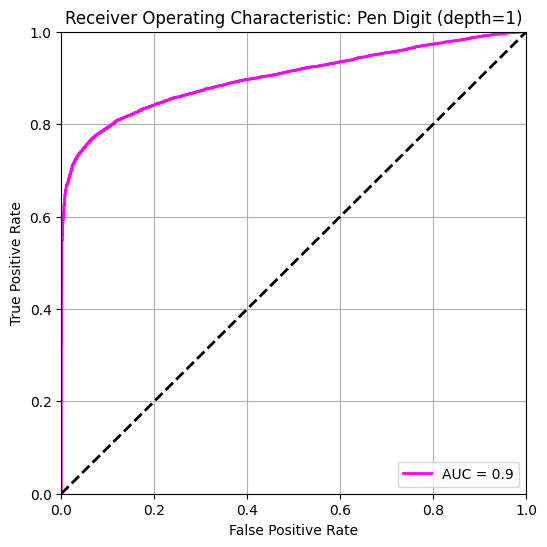

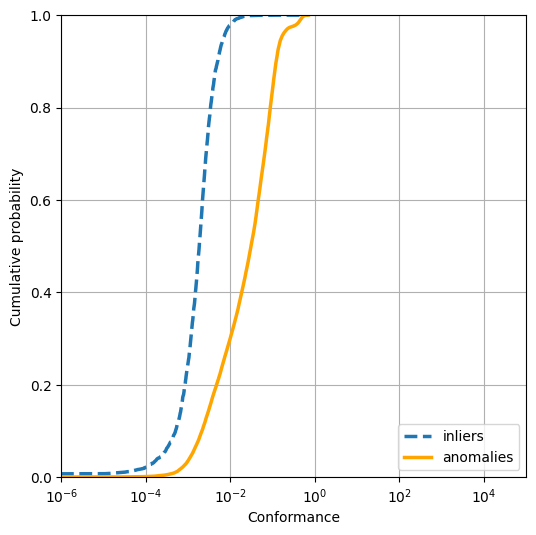

[Overall] depth: 1 | auc: 0.9011937775328175, se: 0.0018076006726148654
start digit: 0, depth: 2
fit_time: 0.22488808631896973
compute_score_time: 1.1644761562347412
depth: 2, digit: 0 | auc: 0.9994156440437432
start digit: 1, depth: 2
fit_time: 0.2208099365234375
compute_score_time: 1.106825828552246
depth: 2, digit: 1 | auc: 0.8821880895109996
start digit: 2, depth: 2
fit_time: 0.2226390838623047
compute_score_time: 1.0340919494628906
depth: 2, digit: 2 | auc: 0.951121867921485
start digit: 3, depth: 2
fit_time: 0.20477533340454102
compute_score_time: 1.059776782989502
depth: 2, digit: 3 | auc: 0.9886656275413391
start digit: 4, depth: 2
fit_time: 0.2190840244293213
compute_score_time: 1.1019721031188965
depth: 2, digit: 4 | auc: 0.9971212578104729
start digit: 5, depth: 2
fit_time: 0.21494412422180176
compute_score_time: 1.0575389862060547
depth: 2, digit: 5 | auc: 0.964771778162617
start digit: 6, depth: 2
fit_time: 0.20235610008239746
compute_score_time: 1.0811340808868408
depth: 

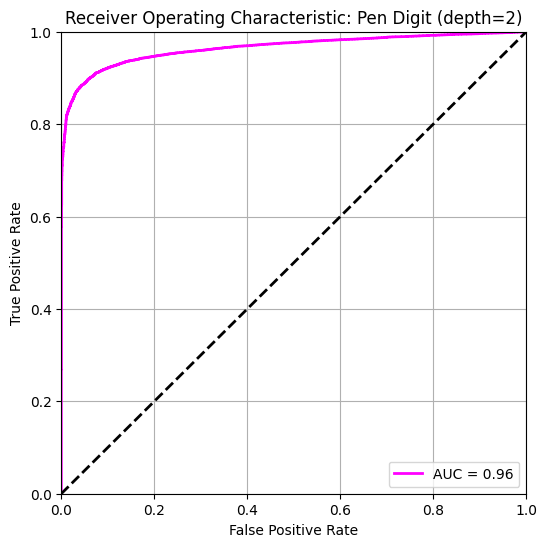

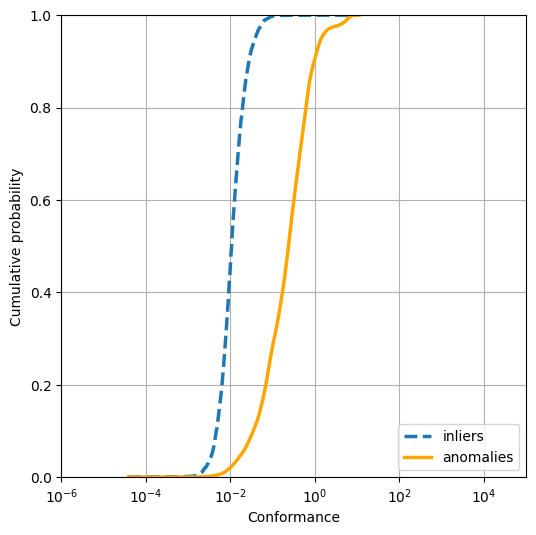

[Overall] depth: 2 | auc: 0.9646518040802645, se: 0.0009820249748333594
start digit: 0, depth: 3
fit_time: 0.23471307754516602
compute_score_time: 1.2222259044647217
depth: 3, digit: 0 | auc: 0.9978321712119015
start digit: 1, depth: 3
fit_time: 0.29467201232910156
compute_score_time: 1.1898539066314697
depth: 3, digit: 1 | auc: 0.970122092330133
start digit: 2, depth: 3
fit_time: 0.24784302711486816
compute_score_time: 1.2419910430908203
depth: 3, digit: 2 | auc: 0.9907229815494015
start digit: 3, depth: 3
fit_time: 0.2189958095550537
compute_score_time: 1.178468942642212
depth: 3, digit: 3 | auc: 0.9952787566639559
start digit: 4, depth: 3
fit_time: 0.219757080078125
compute_score_time: 1.183157205581665
depth: 3, digit: 4 | auc: 0.9998316935138888
start digit: 5, depth: 3
fit_time: 0.18569016456604004
compute_score_time: 1.1506459712982178
depth: 3, digit: 5 | auc: 0.9816601469415489
start digit: 6, depth: 3
fit_time: 0.2125859260559082
compute_score_time: 1.1184279918670654
depth: 

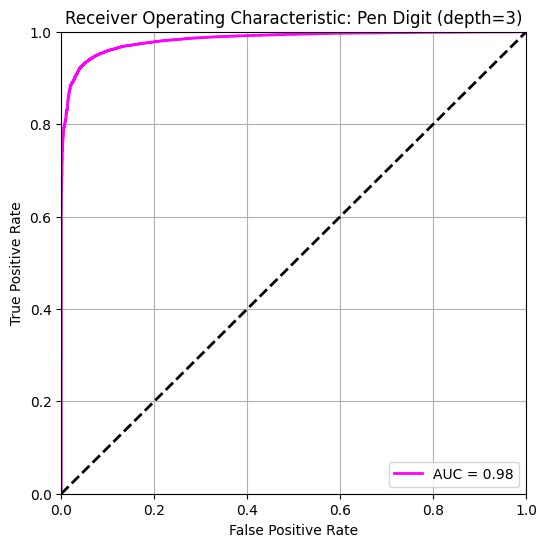

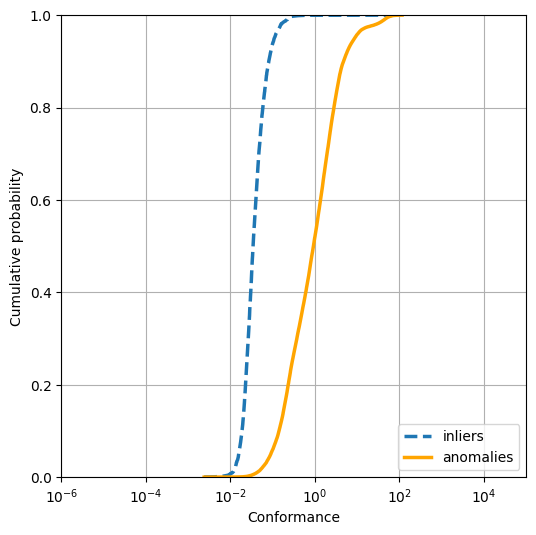

[Overall] depth: 3 | auc: 0.9833028004894407, se: 0.0006938565770073979
start digit: 0, depth: 4
fit_time: 0.2300117015838623
compute_score_time: 1.7579729557037354
depth: 4, digit: 0 | auc: 0.9949666301993401
start digit: 1, depth: 4
fit_time: 0.44178295135498047
compute_score_time: 1.2828309535980225
depth: 4, digit: 1 | auc: 0.9852915909871877
start digit: 2, depth: 4
fit_time: 0.21353697776794434
compute_score_time: 1.4500880241394043
depth: 4, digit: 2 | auc: 0.9894510403444672
start digit: 3, depth: 4
fit_time: 0.2309422492980957
compute_score_time: 1.5821850299835205
depth: 4, digit: 3 | auc: 0.9959715068823227
start digit: 4, depth: 4
fit_time: 0.2325441837310791
compute_score_time: 1.3211109638214111
depth: 4, digit: 4 | auc: 0.9998877956759258
start digit: 5, depth: 4
fit_time: 0.20780110359191895
compute_score_time: 1.5218989849090576
depth: 4, digit: 5 | auc: 0.9878785018945739
start digit: 6, depth: 4
fit_time: 0.2654759883880615
compute_score_time: 1.4919500350952148
dept

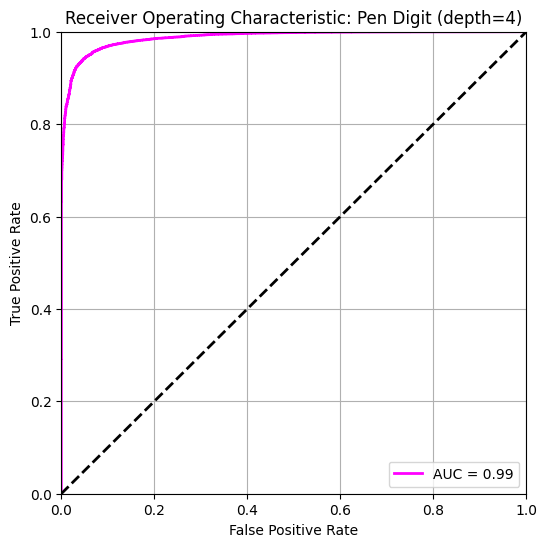

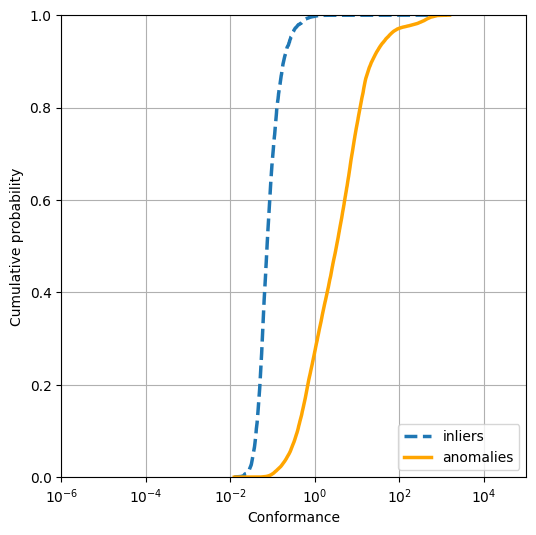

[Overall] depth: 4 | auc: 0.987341800658305, se: 0.0006209417427846002
start digit: 0, depth: 5
fit_time: 0.24412989616394043
compute_score_time: 2.0217630863189697
depth: 5, digit: 0 | auc: 0.9947188281246567
start digit: 1, depth: 5
fit_time: 0.2726559638977051
compute_score_time: 2.2913620471954346
depth: 5, digit: 1 | auc: 0.9902653982902866
start digit: 2, depth: 5
fit_time: 0.3257160186767578
compute_score_time: 2.0212650299072266
depth: 5, digit: 2 | auc: 0.9912200116411987
start digit: 3, depth: 5
fit_time: 0.22621607780456543
compute_score_time: 1.758702039718628
depth: 5, digit: 3 | auc: 0.9964656561549351
start digit: 4, depth: 5
fit_time: 0.25807690620422363
compute_score_time: 1.7370069026947021
depth: 5, digit: 4 | auc: 0.9999298722974537
start digit: 5, depth: 5
fit_time: 0.21524405479431152
compute_score_time: 1.7679202556610107
depth: 5, digit: 5 | auc: 0.9896697354202746
start digit: 6, depth: 5
fit_time: 0.2497880458831787
compute_score_time: 1.5778069496154785
depth

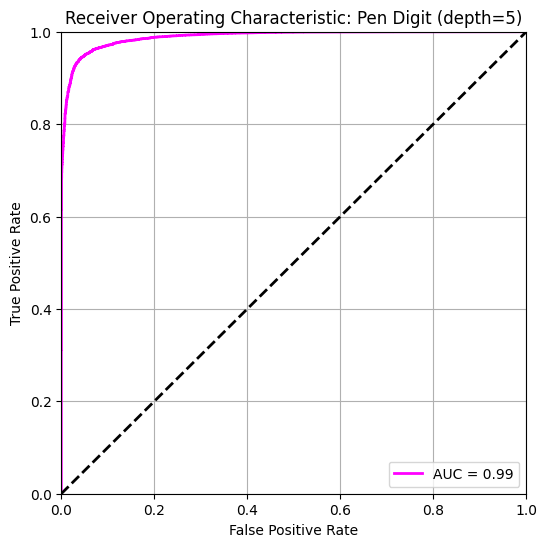

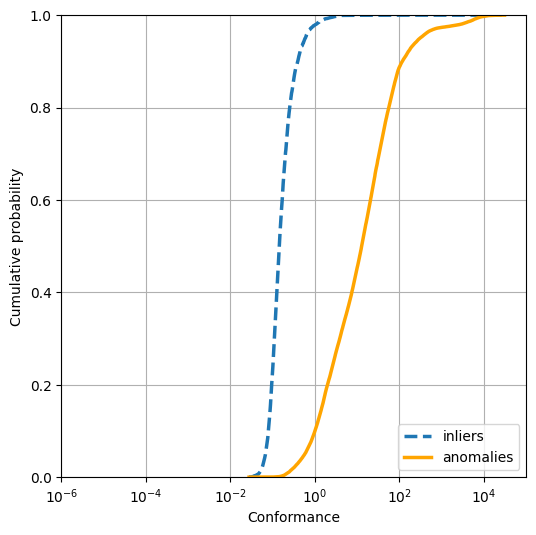

[Overall] depth: 5 | auc: 0.988725068158599, se: 0.0005921693316243689
Total experiment time: 606.2448980808258 seconds | 10.10408163468043 minutes


In [6]:
results_pen_digit_signature_mahalanobis_knn = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_signature_mahalanbois_knn_scores,
    anomaly_detection_kwargs={
        "knn_library": "sklearn",
        "n_neighbours": n_neighbours,
        "random_state": seed,
    },
    add_depth_to_kwargs=True,
    plot_kwargs={"xrange": (10e-7, 10e4), "xlog": True},
)

In [7]:
pd.DataFrame(results_pen_digit_signature_mahalanobis_knn)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.901194,0.001808,"[4.322498083114624, 0.24246668815612793, 0.243...",0.638427,6.384267,"[1.1335527896881104, 1.071739673614502, 1.0874...",1.080082,10.800817
1,2,0.964652,0.000982,"[0.22488808631896973, 0.2208099365234375, 0.22...",0.214666,2.146659,"[1.1644761562347412, 1.106825828552246, 1.0340...",1.106238,11.062379
2,3,0.983303,0.000694,"[0.23471307754516602, 0.29467201232910156, 0.2...",0.234643,2.346427,"[1.2222259044647217, 1.1898539066314697, 1.241...",1.177485,11.774846
3,4,0.987342,0.000621,"[0.2300117015838623, 0.44178295135498047, 0.21...",0.251651,2.516507,"[1.7579729557037354, 1.2828309535980225, 1.450...",1.468930,14.689297
4,5,0.988725,0.000592,"[0.24412989616394043, 0.2726559638977051, 0.32...",0.254169,2.541690,"[2.0217630863189697, 2.2913620471954346, 2.021...",1.856646,18.566462


## Baseline: Isolation Forest

### Using moments as features

start digit: 0, depth: None
fit_time: 0.047418832778930664
compute_score_time: 0.014529943466186523
depth: None, digit: 0 | auc: 0.9399914763116155
start digit: 1, depth: None
fit_time: 0.046138763427734375
compute_score_time: 0.01436471939086914
depth: None, digit: 1 | auc: 0.606004158572761
start digit: 2, depth: None
fit_time: 0.04490494728088379
compute_score_time: 0.013319015502929688
depth: None, digit: 2 | auc: 0.9219189393886267
start digit: 3, depth: None
fit_time: 0.045909881591796875
compute_score_time: 0.015085935592651367
depth: None, digit: 3 | auc: 0.9011804990813529
start digit: 4, depth: None
fit_time: 0.046437978744506836
compute_score_time: 0.012851953506469727
depth: None, digit: 4 | auc: 0.9285521434532283
start digit: 5, depth: None
fit_time: 0.046595096588134766
compute_score_time: 0.014623403549194336
depth: None, digit: 5 | auc: 0.8382132964642486
start digit: 6, depth: None
fit_time: 0.04433608055114746
compute_score_time: 0.01339411735534668
depth: None, digi

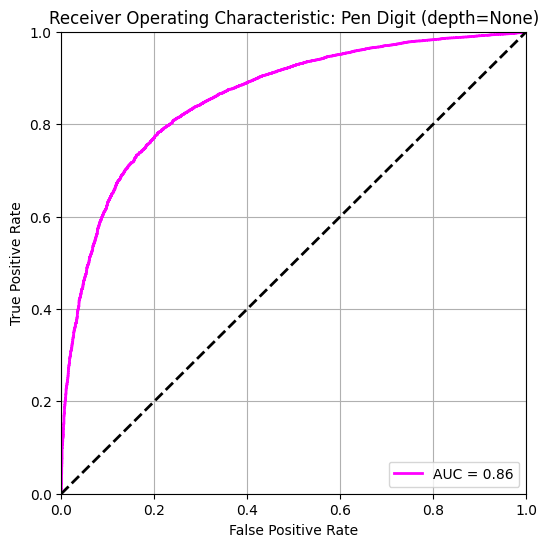

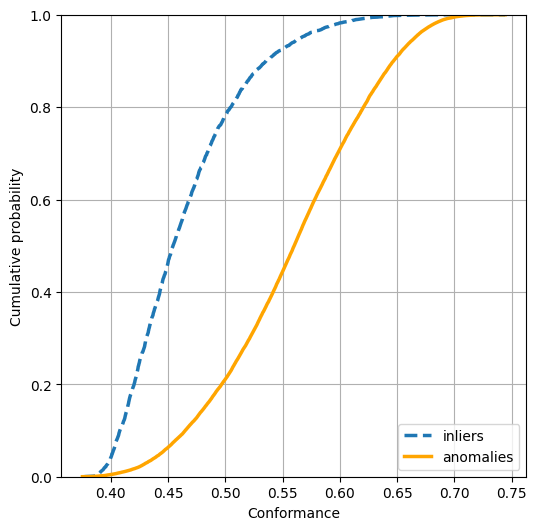

[Overall] depth: None | auc: 0.8593766214670882, se: 0.003082167787676628
Total experiment time: 106.77134394645691 seconds | 1.7795223991076152 minutes


In [8]:
results_pen_digit_isolation_forest_moments = pen_digit_experiment(
    data=data,
    depths=[None],
    digits=digits,
    anomaly_detection_method=compute_isolation_forest_scores_based_on_moments,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=False,
    plot_kwargs=None,
)

In [9]:
pd.DataFrame(results_pen_digit_isolation_forest_moments)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,None,0.859377,0.003082,"[0.047418832778930664, 0.046138763427734375, 0...",0.045874,0.458742,"[0.014529943466186523, 0.01436471939086914, 0....",0.014309,0.143089


### Using path signatures as features

start digit: 0, depth: 1
fit_time: 0.047940969467163086
compute_score_time: 0.012423992156982422
depth: 1, digit: 0 | auc: 0.9524773616987624
start digit: 1, depth: 1
fit_time: 0.04899096488952637
compute_score_time: 0.01576399803161621
depth: 1, digit: 1 | auc: 0.8122834807183881
start digit: 2, depth: 1
fit_time: 0.04883575439453125
compute_score_time: 0.01266789436340332
depth: 1, digit: 2 | auc: 0.9563270966429869
start digit: 3, depth: 1
fit_time: 0.04896187782287598
compute_score_time: 0.013197183609008789
depth: 1, digit: 3 | auc: 0.9342659106653415
start digit: 4, depth: 1
fit_time: 0.04716205596923828
compute_score_time: 0.012866973876953125
depth: 1, digit: 4 | auc: 0.9899397427715871
start digit: 5, depth: 1
fit_time: 0.04885411262512207
compute_score_time: 0.014451980590820312
depth: 1, digit: 5 | auc: 0.9361285573397634
start digit: 6, depth: 1
fit_time: 0.049440860748291016
compute_score_time: 0.013725042343139648
depth: 1, digit: 6 | auc: 0.9211163632119516
start digit: 

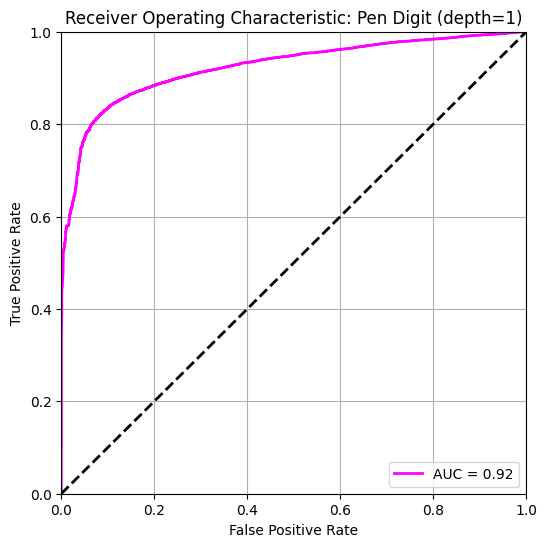

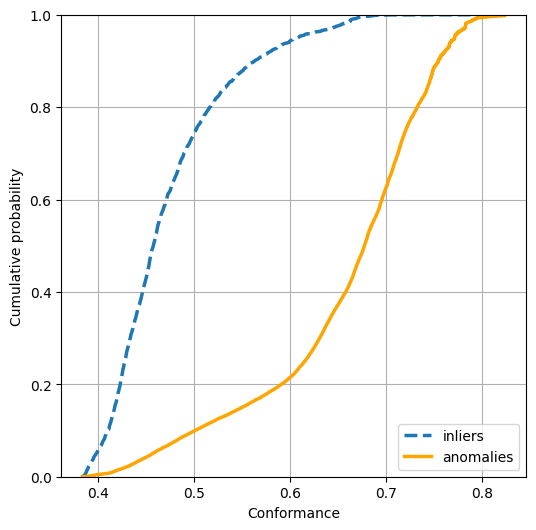

[Overall] depth: 1 | auc: 0.923430603288096, se: 0.001775033920300155
start digit: 0, depth: 2
fit_time: 0.04923701286315918
compute_score_time: 0.009256839752197266
depth: 2, digit: 0 | auc: 0.9997750449251102
start digit: 1, depth: 2
fit_time: 0.04681205749511719
compute_score_time: 0.01590895652770996
depth: 2, digit: 1 | auc: 0.806022830073564
start digit: 2, depth: 2
fit_time: 0.046885013580322266
compute_score_time: 0.013679027557373047
depth: 2, digit: 2 | auc: 0.9540821335652223
start digit: 3, depth: 2
fit_time: 0.04716205596923828
compute_score_time: 0.010863065719604492
depth: 2, digit: 3 | auc: 0.9889734119454233
start digit: 4, depth: 2
fit_time: 0.04598665237426758
compute_score_time: 0.010483026504516602
depth: 2, digit: 4 | auc: 0.9969038619325792
start digit: 5, depth: 2
fit_time: 0.0506742000579834
compute_score_time: 0.014166116714477539
depth: 2, digit: 5 | auc: 0.9594169525436366
start digit: 6, depth: 2
fit_time: 0.04982399940490723
compute_score_time: 0.012799978

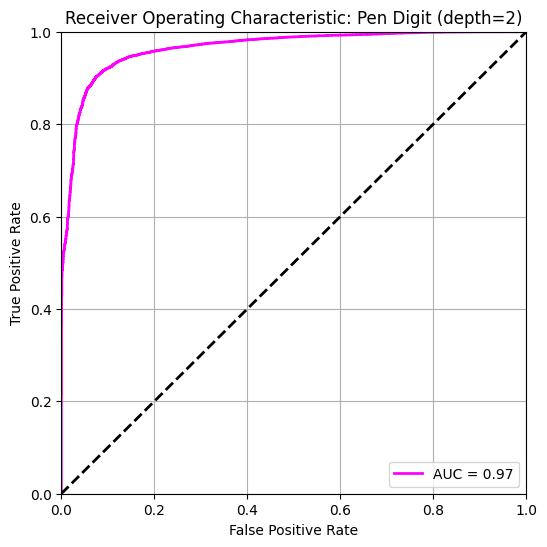

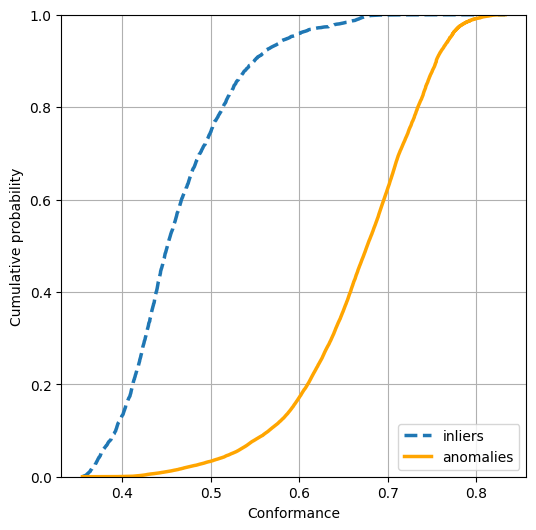

[Overall] depth: 2 | auc: 0.9650903868071091, se: 0.0013474236945676993
start digit: 0, depth: 3
fit_time: 0.04793906211853027
compute_score_time: 0.010350942611694336
depth: 3, digit: 0 | auc: 0.9992987728524919
start digit: 1, depth: 3
fit_time: 0.04825925827026367
compute_score_time: 0.015572071075439453
depth: 3, digit: 1 | auc: 0.8368496532185109
start digit: 2, depth: 3
fit_time: 0.04685211181640625
compute_score_time: 0.013727903366088867
depth: 3, digit: 2 | auc: 0.9755622488551653
start digit: 3, depth: 3
fit_time: 0.04790616035461426
compute_score_time: 0.011413097381591797
depth: 3, digit: 3 | auc: 0.9923289208156382
start digit: 4, depth: 3
fit_time: 0.045723915100097656
compute_score_time: 0.011616945266723633
depth: 3, digit: 4 | auc: 0.9970651556484358
start digit: 5, depth: 3
fit_time: 0.04585695266723633
compute_score_time: 0.013240814208984375
depth: 3, digit: 5 | auc: 0.9334242477149504
start digit: 6, depth: 3
fit_time: 0.04663205146789551
compute_score_time: 0.0119

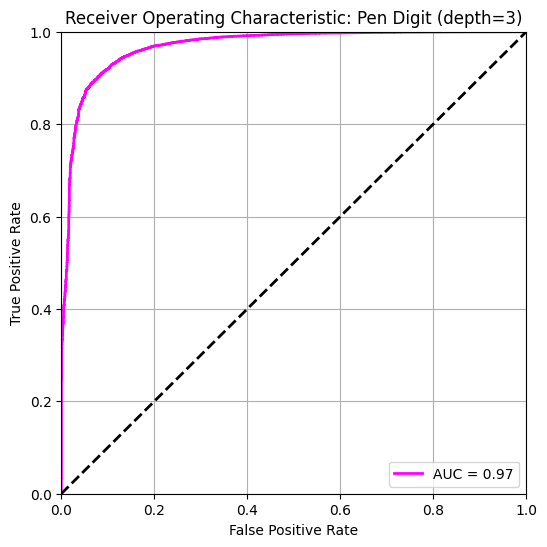

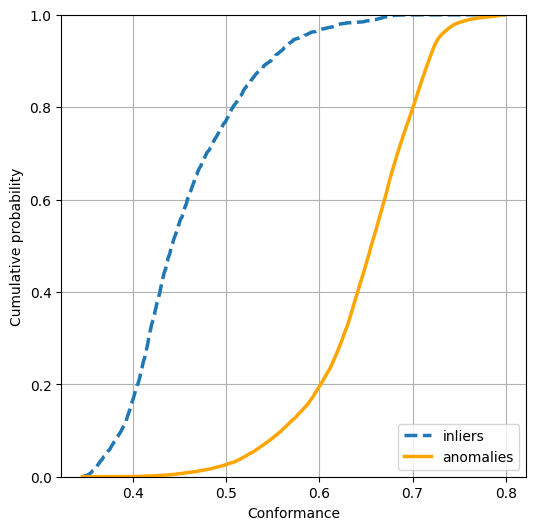

[Overall] depth: 3 | auc: 0.9686152167543152, se: 0.001470747188396025
start digit: 0, depth: 4
fit_time: 0.047960758209228516
compute_score_time: 0.009572029113769531
depth: 4, digit: 0 | auc: 0.9999630933080259
start digit: 1, depth: 4
fit_time: 0.05010724067687988
compute_score_time: 0.015172958374023438
depth: 4, digit: 1 | auc: 0.8952800549801189
start digit: 2, depth: 4
fit_time: 0.06301188468933105
compute_score_time: 0.017388105392456055
depth: 4, digit: 2 | auc: 0.973581141258231
start digit: 3, depth: 4
fit_time: 0.04896998405456543
compute_score_time: 0.011749267578125
depth: 4, digit: 3 | auc: 0.9934753471280986
start digit: 4, depth: 4
fit_time: 0.04601693153381348
compute_score_time: 0.012989997863769531
depth: 4, digit: 4 | auc: 0.9971028492885544
start digit: 5, depth: 4
fit_time: 0.04770088195800781
compute_score_time: 0.013794183731079102
depth: 4, digit: 5 | auc: 0.8884650412181899
start digit: 6, depth: 4
fit_time: 0.0471951961517334
compute_score_time: 0.0123841762

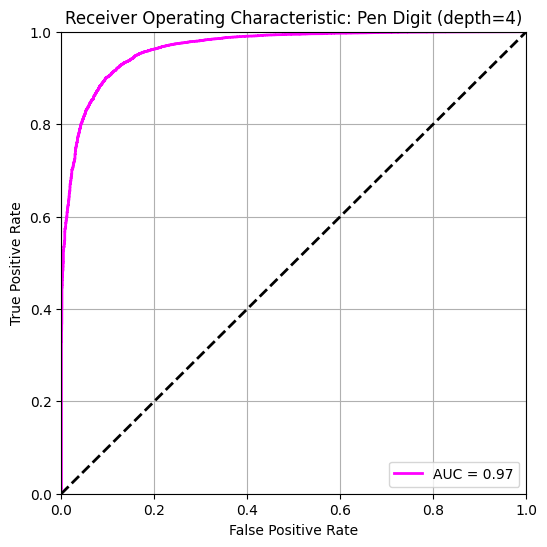

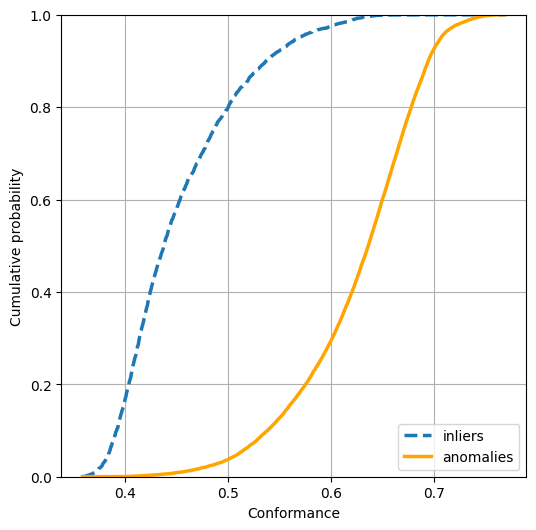

[Overall] depth: 4 | auc: 0.9655765613239964, se: 0.001384987543996005
start digit: 0, depth: 5
fit_time: 0.0448760986328125
compute_score_time: 0.009418964385986328
depth: 5, digit: 0 | auc: 0.9866696543512551
start digit: 1, depth: 5
fit_time: 0.04642891883850098
compute_score_time: 0.013845205307006836
depth: 5, digit: 1 | auc: 0.9291797863910181
start digit: 2, depth: 5
fit_time: 0.04778289794921875
compute_score_time: 0.014447927474975586
depth: 5, digit: 2 | auc: 0.9663281836223763
start digit: 3, depth: 5
fit_time: 0.04823184013366699
compute_score_time: 0.011687994003295898
depth: 5, digit: 3 | auc: 0.9939130221981265
start digit: 4, depth: 5
fit_time: 0.047625064849853516
compute_score_time: 0.013448953628540039
depth: 5, digit: 4 | auc: 0.9947360393276156
start digit: 5, depth: 5
fit_time: 0.052137136459350586
compute_score_time: 0.013447999954223633
depth: 5, digit: 5 | auc: 0.8853412356491334
start digit: 6, depth: 5
fit_time: 0.045387983322143555
compute_score_time: 0.0116

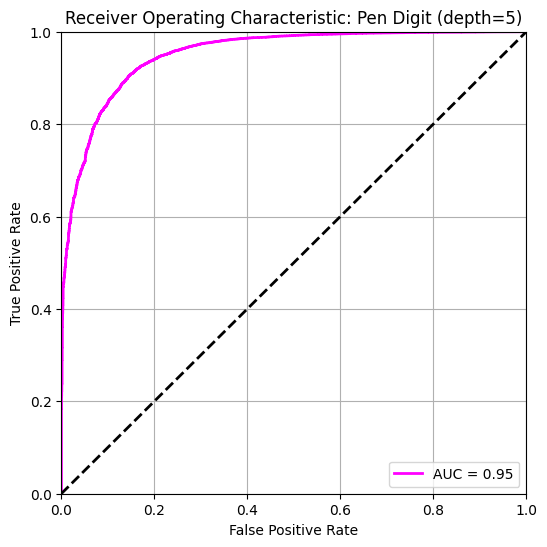

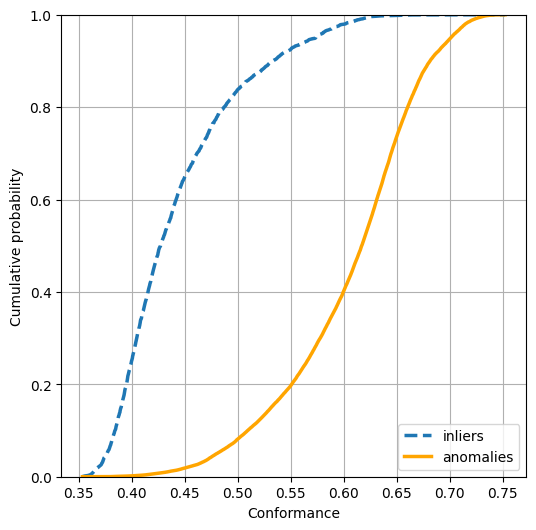

[Overall] depth: 5 | auc: 0.9512470374769046, se: 0.001773228647728184
Total experiment time: 577.7103230953217 seconds | 9.628505384922027 minutes


In [10]:
results_pen_digit_isolation_forest_signatures = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_isolation_forest_scores_signatures,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=True,
    plot_kwargs=None,
)

In [11]:
pd.DataFrame(results_pen_digit_isolation_forest_signatures)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.923431,0.001775,"[0.047940969467163086, 0.04899096488952637, 0....",0.048220,0.482204,"[0.012423992156982422, 0.01576399803161621, 0....",0.013434,0.134343
1,2,0.965090,0.001347,"[0.04923701286315918, 0.04681205749511719, 0.0...",0.047633,0.476331,"[0.009256839752197266, 0.01590895652770996, 0....",0.012701,0.127015
2,3,0.968615,0.001471,"[0.04793906211853027, 0.04825925827026367, 0.0...",0.047099,0.470994,"[0.010350942611694336, 0.015572071075439453, 0...",0.012783,0.127831
3,4,0.965577,0.001385,"[0.047960758209228516, 0.05010724067687988, 0....",0.049692,0.496916,"[0.009572029113769531, 0.015172958374023438, 0...",0.013392,0.133916
4,5,0.951247,0.001773,"[0.0448760986328125, 0.04642891883850098, 0.04...",0.048073,0.480732,"[0.009418964385986328, 0.013845205307006836, 0...",0.013339,0.133386


## Baseline: Local Outlier Factor


### Using moments as features

start digit: 0, depth: None
fit_time: 0.0779569149017334
compute_score_time: 1.0967254638671875e-05
depth: None, digit: 0 | auc: 0.6771481671873147
start digit: 1, depth: None
fit_time: 0.07589197158813477
compute_score_time: 0.00013589859008789062
depth: None, digit: 1 | auc: 0.42980129315483495
start digit: 2, depth: None
fit_time: 0.07930612564086914
compute_score_time: 1.0013580322265625e-05
depth: None, digit: 2 | auc: 0.6079537087035491
start digit: 3, depth: None
fit_time: 0.07702493667602539
compute_score_time: 1.1205673217773438e-05
depth: None, digit: 3 | auc: 0.7008081458389808
start digit: 4, depth: None
fit_time: 0.07768106460571289
compute_score_time: 1.0013580322265625e-05
depth: None, digit: 4 | auc: 0.46858980202949574
start digit: 5, depth: None
fit_time: 0.07493400573730469
compute_score_time: 1.0967254638671875e-05
depth: None, digit: 5 | auc: 0.570254953496822
start digit: 6, depth: None
fit_time: 0.07491683959960938
compute_score_time: 1.1682510375976562e-05
depth

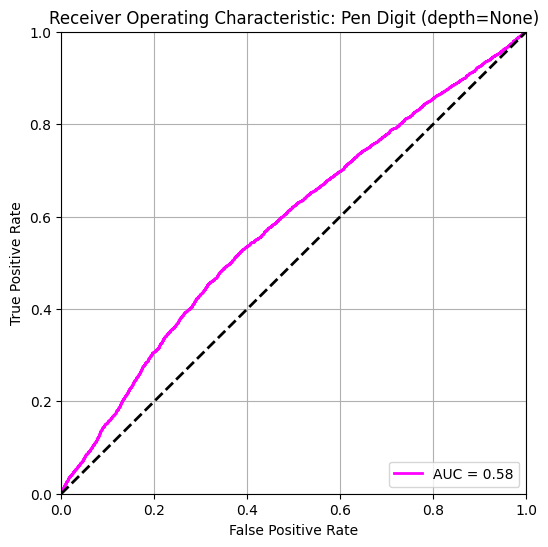

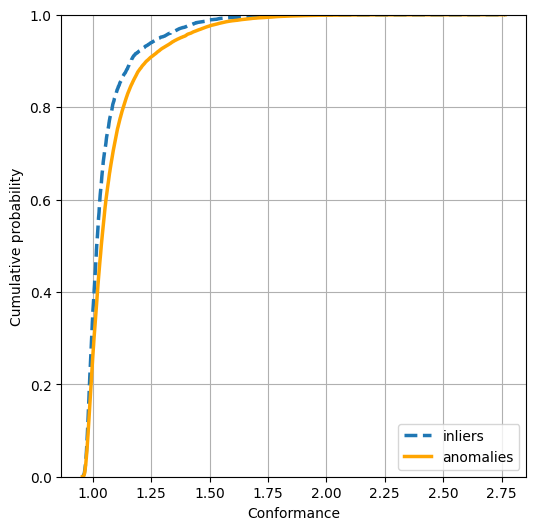

[Overall] depth: None | auc: 0.5803546738879058, se: 0.004943693092663726
Total experiment time: 107.3341748714447 seconds | 1.7889029145240785 minutes


In [19]:
results_pen_digit_local_outlier_factor_moments = pen_digit_experiment(
    data=data,
    depths=[None],
    digits=digits,
    anomaly_detection_method=compute_local_outlier_factor_scores_based_on_moments,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=False,
    plot_kwargs=None,
)

In [20]:
pd.DataFrame(results_pen_digit_local_outlier_factor_moments)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,None,0.580355,0.004944,"[0.0779569149017334, 0.07589197158813477, 0.07...",0.07666,0.766599,"[1.0967254638671875e-05, 0.0001358985900878906...",0.000023,0.000234


### Using path signatures as features

start digit: 0, depth: 1
fit_time: 0.041916847229003906
compute_score_time: 1.6927719116210938e-05
depth: 1, digit: 0 | auc: 0.48151721653244056
start digit: 1, depth: 1
fit_time: 0.04588174819946289
compute_score_time: 3.6716461181640625e-05
depth: 1, digit: 1 | auc: 0.525467751775984
start digit: 2, depth: 1
fit_time: 0.043589115142822266
compute_score_time: 8.821487426757812e-05
depth: 1, digit: 2 | auc: 0.5991141117975833
start digit: 3, depth: 1
fit_time: 0.04175996780395508
compute_score_time: 3.0279159545898438e-05
depth: 1, digit: 3 | auc: 0.589914460407819
start digit: 4, depth: 1
fit_time: 0.04092597961425781
compute_score_time: 1.8835067749023438e-05
depth: 1, digit: 4 | auc: 0.5939851469526007
start digit: 5, depth: 1
fit_time: 0.04016304016113281
compute_score_time: 1.3113021850585938e-05
depth: 1, digit: 5 | auc: 0.5930275904700336
start digit: 6, depth: 1
fit_time: 0.041709184646606445
compute_score_time: 2.09808349609375e-05
depth: 1, digit: 6 | auc: 0.5259160115659167


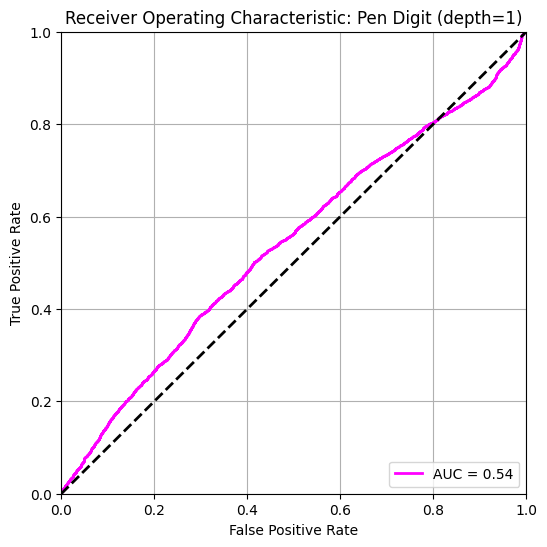

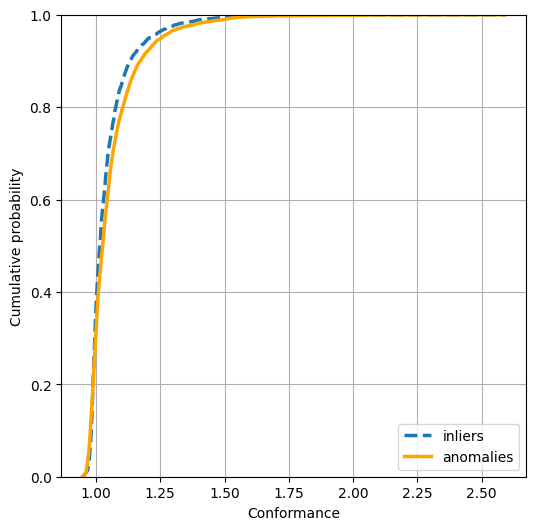

[Overall] depth: 1 | auc: 0.5385550889180997, se: 0.004835071236614287
start digit: 0, depth: 2
fit_time: 0.06672811508178711
compute_score_time: 2.09808349609375e-05
depth: 2, digit: 0 | auc: 0.4586781253157938
start digit: 1, depth: 2
fit_time: 0.06737804412841797
compute_score_time: 2.09808349609375e-05
depth: 2, digit: 1 | auc: 0.5931103038633352
start digit: 2, depth: 2
fit_time: 0.06478309631347656
compute_score_time: 2.7894973754882812e-05
depth: 2, digit: 2 | auc: 0.5291801370295308
start digit: 3, depth: 2
fit_time: 0.06406497955322266
compute_score_time: 1.52587890625e-05
depth: 2, digit: 3 | auc: 0.5322382985452245
start digit: 4, depth: 2
fit_time: 0.06601405143737793
compute_score_time: 1.3113021850585938e-05
depth: 2, digit: 4 | auc: 0.47678334747575335
start digit: 5, depth: 2
fit_time: 0.06458592414855957
compute_score_time: 2.9087066650390625e-05
depth: 2, digit: 5 | auc: 0.5788666531396134
start digit: 6, depth: 2
fit_time: 0.06647205352783203
compute_score_time: 2.40

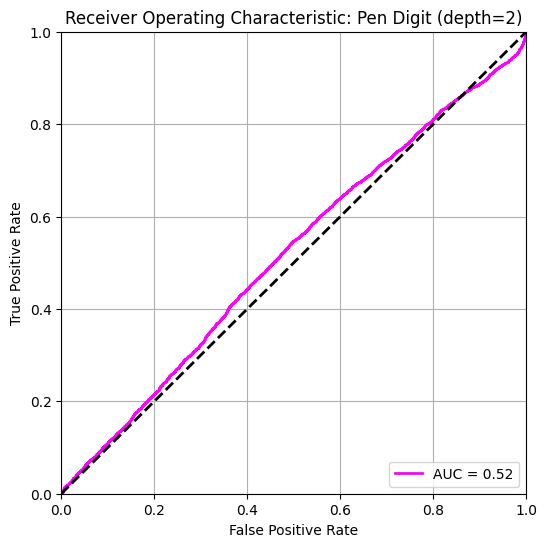

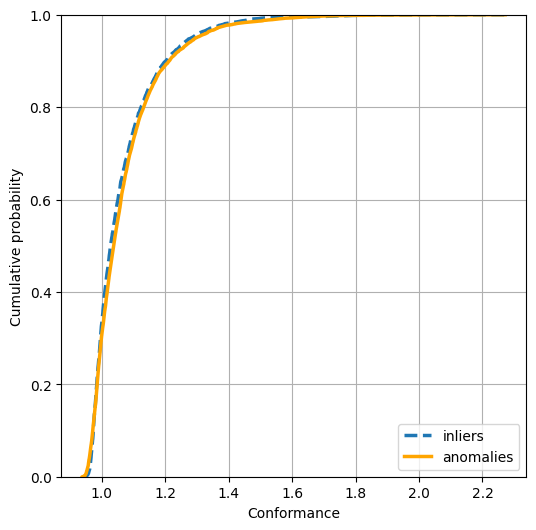

[Overall] depth: 2 | auc: 0.517935793780751, se: 0.005115725075568742
start digit: 0, depth: 3
fit_time: 0.10119795799255371
compute_score_time: 1.9073486328125e-05
depth: 3, digit: 0 | auc: 0.4793599325134775
start digit: 1, depth: 3
fit_time: 0.10642695426940918
compute_score_time: 1.6927719116210938e-05
depth: 3, digit: 1 | auc: 0.6151523173699307
start digit: 2, depth: 3
fit_time: 0.1044919490814209
compute_score_time: 2.8848648071289062e-05
depth: 3, digit: 2 | auc: 0.5302013716978617
start digit: 3, depth: 3
fit_time: 0.09675383567810059
compute_score_time: 1.1205673217773438e-05
depth: 3, digit: 3 | auc: 0.5199222161983073
start digit: 4, depth: 3
fit_time: 0.10321426391601562
compute_score_time: 1.9788742065429688e-05
depth: 3, digit: 4 | auc: 0.49779010077350855
start digit: 5, depth: 3
fit_time: 0.10003113746643066
compute_score_time: 2.8133392333984375e-05
depth: 3, digit: 5 | auc: 0.5832956620627499
start digit: 6, depth: 3
fit_time: 0.10285782814025879
compute_score_time: 

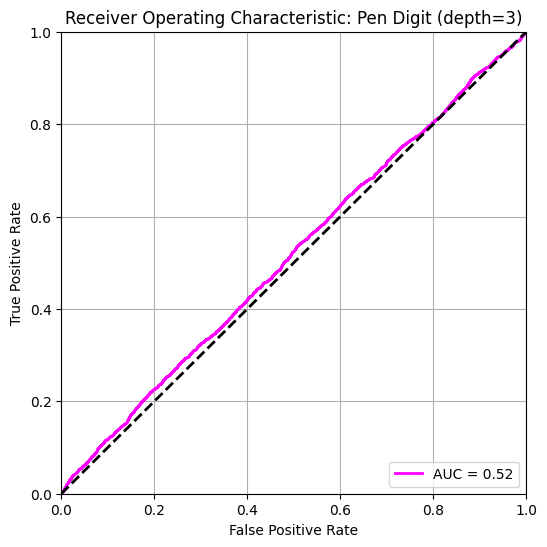

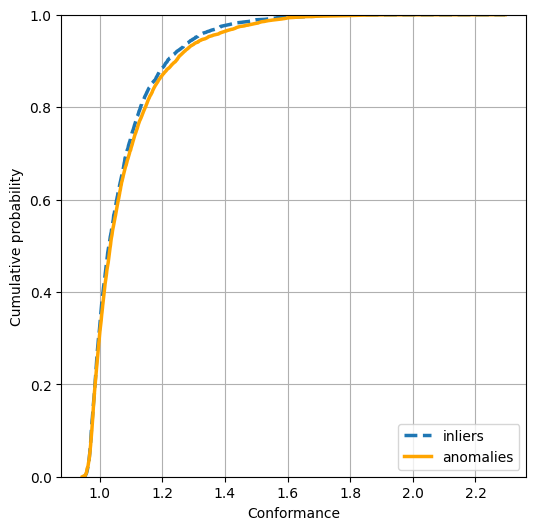

[Overall] depth: 3 | auc: 0.5155470782055245, se: 0.005078747930273206
start digit: 0, depth: 4
fit_time: 0.09587407112121582
compute_score_time: 2.9087066650390625e-05
depth: 4, digit: 0 | auc: 0.48586605507005676
start digit: 1, depth: 4
fit_time: 0.08135080337524414
compute_score_time: 2.7179718017578125e-05
depth: 4, digit: 1 | auc: 0.615951773178959
start digit: 2, depth: 4
fit_time: 0.08820199966430664
compute_score_time: 2.002716064453125e-05
depth: 4, digit: 2 | auc: 0.5272156847619516
start digit: 3, depth: 4
fit_time: 0.10554122924804688
compute_score_time: 4.9114227294921875e-05
depth: 4, digit: 3 | auc: 0.5084118324749255
start digit: 4, depth: 4
fit_time: 0.0897216796875
compute_score_time: 2.7179718017578125e-05
depth: 4, digit: 4 | auc: 0.4956924058710913
start digit: 5, depth: 4
fit_time: 0.11419796943664551
compute_score_time: 1.5020370483398438e-05
depth: 4, digit: 5 | auc: 0.581213754181983
start digit: 6, depth: 4
fit_time: 0.09972620010375977
compute_score_time: 1.

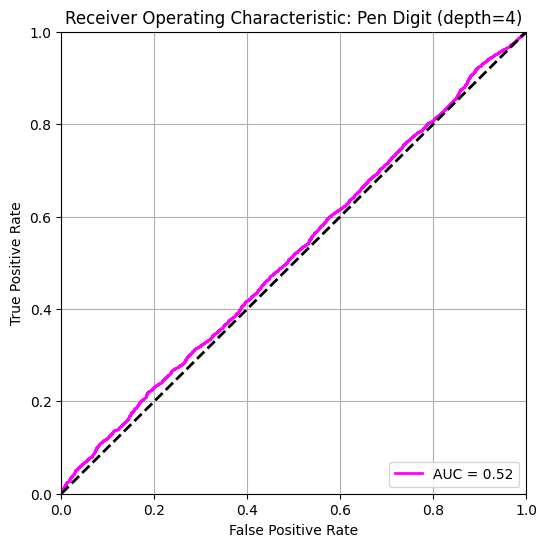

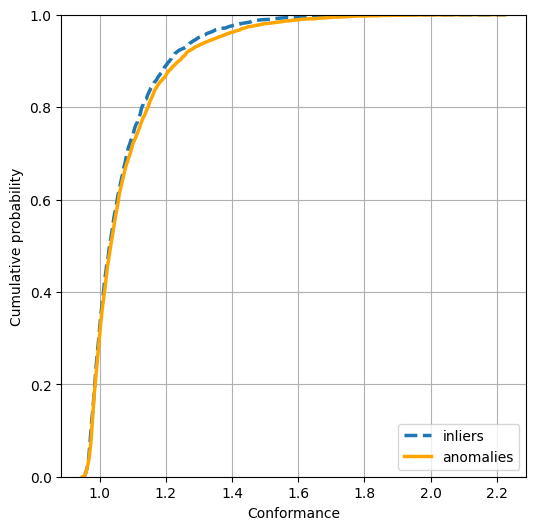

[Overall] depth: 4 | auc: 0.5159365481301467, se: 0.005079883849477212
start digit: 0, depth: 5
fit_time: 0.08606910705566406
compute_score_time: 1.6927719116210938e-05
depth: 5, digit: 0 | auc: 0.4888045307358052
start digit: 1, depth: 5
fit_time: 0.10160088539123535
compute_score_time: 1.9073486328125e-05
depth: 5, digit: 1 | auc: 0.6175392890453516
start digit: 2, depth: 5
fit_time: 0.09714913368225098
compute_score_time: 1.3828277587890625e-05
depth: 5, digit: 2 | auc: 0.5237022868643801
start digit: 3, depth: 5
fit_time: 0.08867192268371582
compute_score_time: 1.9073486328125e-05
depth: 5, digit: 3 | auc: 0.5037922427035331
start digit: 4, depth: 5
fit_time: 0.14792513847351074
compute_score_time: 2.9087066650390625e-05
depth: 5, digit: 4 | auc: 0.4941136559675169
start digit: 5, depth: 5
fit_time: 0.12357497215270996
compute_score_time: 2.3126602172851562e-05
depth: 5, digit: 5 | auc: 0.5810410483151741
start digit: 6, depth: 5
fit_time: 0.22027277946472168
compute_score_time: 2.

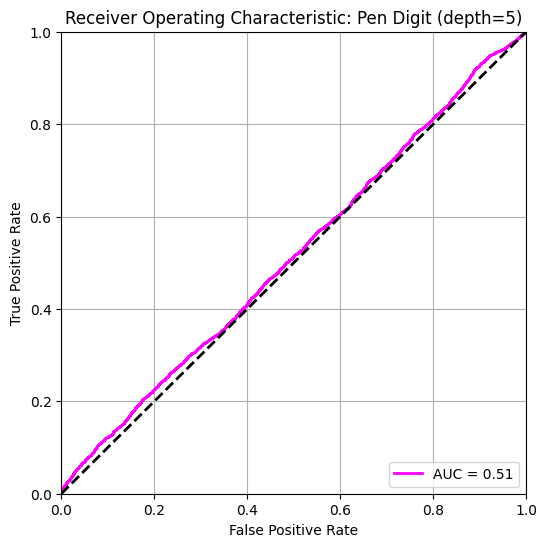

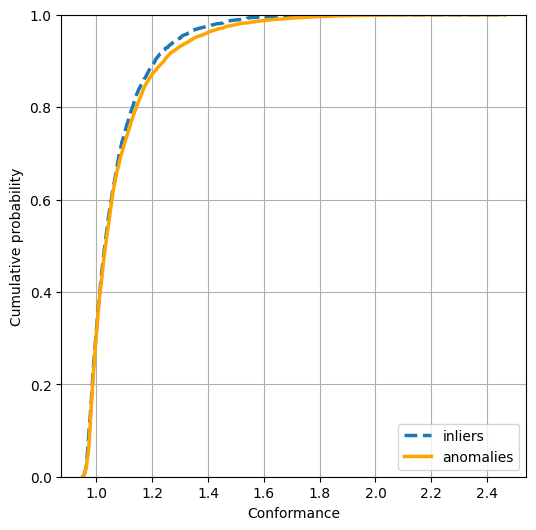

[Overall] depth: 5 | auc: 0.5142120381421545, se: 0.005081811746978838
Total experiment time: 589.2011480331421 seconds | 9.820019133885701 minutes


In [21]:
results_pen_digit_local_outlier_factor_signatures = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_local_outlier_factor_scores_signatures,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=True,
    plot_kwargs=None,
)

In [22]:
pd.DataFrame(results_pen_digit_local_outlier_factor_signatures)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.538555,0.004835,"[0.041916847229003906, 0.04588174819946289, 0....",0.041966,0.419665,"[1.6927719116210938e-05, 3.6716461181640625e-0...",0.000029,0.000285
1,2,0.517936,0.005116,"[0.06672811508178711, 0.06737804412841797, 0.0...",0.065966,0.659662,"[2.09808349609375e-05, 2.09808349609375e-05, 2...",0.000020,0.000202
2,3,0.515547,0.005079,"[0.10119795799255371, 0.10642695426940918, 0.1...",0.103335,1.033347,"[1.9073486328125e-05, 1.6927719116210938e-05, ...",0.000023,0.000227
3,4,0.515937,0.005080,"[0.09587407112121582, 0.08135080337524414, 0.0...",0.098881,0.988808,"[2.9087066650390625e-05, 2.7179718017578125e-0...",0.000026,0.000260
4,5,0.514212,0.005082,"[0.08606910705566406, 0.10160088539123535, 0.0...",0.125552,1.255521,"[1.6927719116210938e-05, 1.9073486328125e-05, ...",0.000022,0.000219
